In [3]:
from pathlib import Path
import regex as re

In [53]:
# take text line by line from source files
def read_text(path):
    with Path(path).open(encoding="utf-8") as file:
        for line in file:
            line = line.strip()
            if line:
                yield line # yield keyword more memory and time efficient for line by line processing than returning full list of sentences all at once

In [54]:
# normalizing text - all lowercase letters, get rid of numbers and special symbols.
def normalize_text(text):
    return re.sub(r"[^\p{L}\s]", "", text.lower())

In [55]:
# process for cleaning one file
def preprocess_file(input_path, output_path):
    with open(output_path, "w", encoding="utf-8") as output:
        for i in read_text(input_path):
            clean = normalize_text(i)
            if clean:
                output.write(clean + "\n")

In [56]:
# process for cleaning a directory
def preprocess_dir(root_dir, output_root):
    root_dir = Path(root_dir)
    output_root = Path(output_root)
    for file in root_dir.rglob("*"):
        if file.is_file():
            rel_path = file.relative_to(root_dir) # extracts relative path
            output_file = output_root / rel_path # creates a new path for the output file
            output_folder = output_file.parent
            if output_folder.exists():
                continue
            output_file.parent.mkdir(parents = True, exist_ok = True) # creates any necessary parent directories if they dont already exist, as well as suppressing an error if the parents already exist
            preprocess_file(file, output_file) 

In [57]:
# call functions to clean source directories
preprocess_dir("SOURCE", "CLEANED")

In [58]:
from collections import Counter
import json

In [59]:
# create ngrams of length n, do not include ngrams with newline character
def char_ngrams(text, n):
    return [text[i:i+n] for i in range(len(text)-n+1) if '\n' not in text[i:i+n]]

In [60]:
def get_freq_vector(ngrams):
    counts = Counter(ngrams) # stores the count of ngrams as key-value pairs
    total = sum(counts.values()) # total number of ngrams
    return {k: v/total for k, v in counts.items()} # returns a dictionary with each unique ngram as the key and the frequency as the value

In [61]:
# creates language vectors 
def ngram_frequencies_by_language(root_dir, n = 3):
    lang_vectors = {} # create a dictionary to store the language vectors
    root = Path(root_dir)

    for lang_dir in root.iterdir(): # iterates through the root directory
        print(lang_dir) # print statement to track progress
        if lang_dir.is_dir():
            all_text = [] # make a list to store the text
            for file in lang_dir.rglob("*"): # goes through all files inside the directory
                # appends the text in the file to the all_text list if the file is valid
                if file.is_file():
                    all_text.append(file.read_text(encoding="utf-8"))
            text = "\n".join(all_text) # joins all the text together with newline characters
            ngrams = char_ngrams(text, n) # creates ngrams
            lang_vectors[lang_dir.name] = get_freq_vector(ngrams) # returns dictionary of language vectors.

    return lang_vectors # return our language vectors

In [62]:
# calling functions to actually create language vectors
vectors = ngram_frequencies_by_language("CLEANED", 3)

with open("language_ngram_vectors.json", "w", encoding="utf-8") as file: # write all the vectors to a json file
    json.dump(vectors, file, ensure_ascii=False, indent=2)

CLEANED\Dutch
CLEANED\English
CLEANED\French
CLEANED\German
CLEANED\Indonesian
CLEANED\Italian
CLEANED\Portuguese
CLEANED\Romanian
CLEANED\Spanish
CLEANED\Swedish
CLEANED\Turkish
CLEANED\Vietnamese


In [63]:
import json
import numpy as np
import umap
import matplotlib.pyplot as plt
from numpy.linalg import norm

In [64]:
# load language vectors from desired file
with open("language_ngram_vectors.json", "r", encoding="utf-8") as f:
    lang_vectors = json.load(f)

# need to create a list of all unique n_grams that appear in all of our texts
all_ngrams_set = set() # start with a set to avoid duplicates

for lang_vector in lang_vectors.values(): # loop over the language vectors
    for n_gram in lang_vector: # loop over the ngrams in the language vector
        all_ngrams_set.add(n_gram) # add the ngram to the set

all_ngrams = sorted(all_ngrams_set) # convert to a sorted list (sorted for reproducibility, since sets are unordered)
names = list(lang_vectors.keys()) # list stores the names of the languages we are working with

# creates a matrix where each row corresponds to a language, each column corresponds to an ngram, and each entry is defined as the frequency of that ngram within the languages text
matrix = np.array([
    [lang_vectors[language].get(n_gram, 0.0) for n_gram in all_ngrams]
    for language in names
], dtype=float)

In [65]:
# Pairwise cosine distance
# cosine similarity = dot(a,b)/(||a||*||b||)
dot_products = matrix @ matrix.T # find dot products between each language
norms = norm(matrix, axis=1) # find norms of each vector
cosine_similarity = dot_products / np.outer(norms, norms) # compute cosine similarity
distance = np.clip(1.0 - cosine_similarity, 0.0, None)   # computes symmetric distance matrix

In [73]:
# UMAP embedding
reducer = umap.UMAP(metric="cosine", n_components=2, random_state=42, n_neighbors=3, n_jobs=1) # create a reducer using the cosine similarity metric
embedding = reducer.fit_transform(distance) # make an embedding from the reducer using our distance matrix 

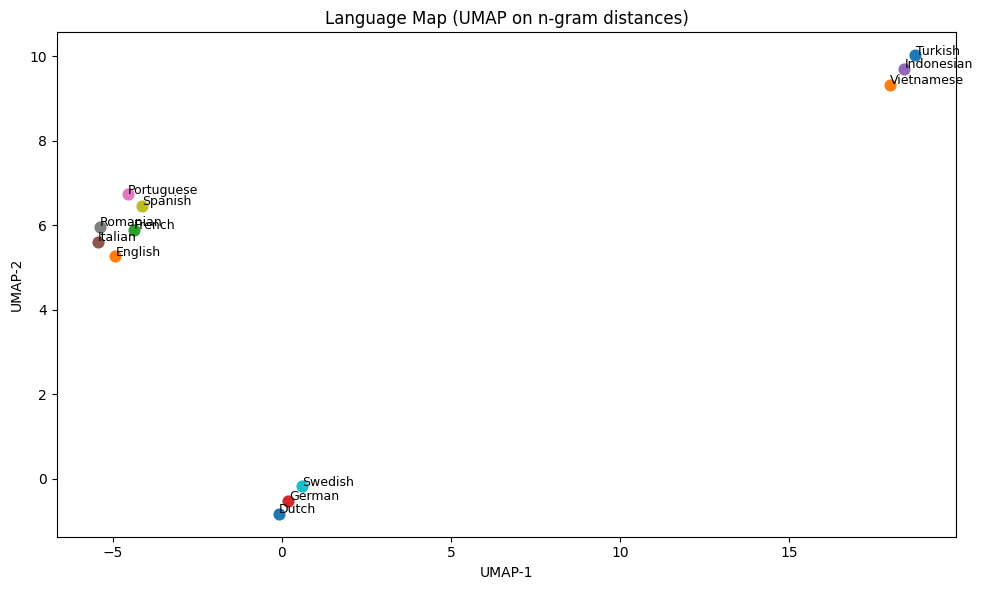

In [74]:
# plotting
plt.figure(figsize=(10, 6))
for i, lang in enumerate(names):
    x, y = embedding[i]
    plt.scatter(x, y, s=60)
    plt.text(x + 0.01, y + 0.01, lang, fontsize=9)
plt.title("Language Map (UMAP on n-gram distances)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

In [75]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import torch.nn as nn
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from torchmetrics import Accuracy

In [76]:
with open("language_ngram_vectors.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data).fillna(0).T # make dataframe with ngram frequency per language - fill NA entries with 0, and take transpose.
languages = df.index.tolist() # get list of language names
label_map = {lang: i for i, lang in enumerate(languages)} # associate each language with a number

features = torch.tensor(df.values, dtype=torch.float32) # frequency values for each language
targets = torch.tensor([label_map[lang] for lang in languages], dtype=torch.int64) # numbers for each language

dataset = TensorDataset(features, targets) # convert data to a torch tensor
dataloader = DataLoader(dataset, batch_size=4, shuffle=True) # create an iterable to train the model on the data

In [79]:
# define a simple neural network (multi layer perceptron)
class MLPClassifier(nn.Module):
    # our model will consist of a linear layer, a ReLU activation function to introduce non linearity, and another linear layer to map our hidden features to outputs
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    # forward pass (passes the input tensor through the layers in sequence)
    def forward(self, x):
        return self.model(x)

In [80]:
# training loop
def train(model, optimizer, dataloader, epochs):
    # create an accuracy metric to track classification performance
    accuracy = Accuracy(task = "multiclass", num_classes=len(languages))
    # create variables to help compute AVERAGE accuracy over all epochs
    total_acc = 0
    count = 0

    for epoch in range(epochs): # loop over the dataset
        for x, target in dataloader: # iterate over batches from dataloader
            pred = model(x) # compute model predictions
            loss = cross_entropy(pred, target) # compute cross entropy loss between the models predictions and the expected result
            loss.backward() # back propagation - compute gradients
            optimizer.step() # update model parameters
            optimizer.zero_grad() # reset the gradients
            total_acc += accuracy(pred, target).item() # compute accuracy for the previous epoch
            count += 1 # increment the count of epochs completed
        avg_acc = total_acc / count # update the average accuracy
        if epoch % 10 == 0: # prints progress updates for training every 10 epochs 
            print(f"Epoch {epoch}: loss={loss.item():.3f}, acc={avg_acc:.3f}")

In [81]:
input_dim = features.shape[1] # get dimension of input 
hidden_dim = 128 # number of neurons in the hidden layer 
output_dim = len(languages) # an output neuron for each language we need to classify

model = MLPClassifier(input_dim, hidden_dim, output_dim) # create an instance of our neural network!
optimizer = Adam(model.parameters(), lr=0.01) # initialize an optimizer!

train(model, optimizer, dataloader, epochs=200) # call training loop

Epoch 0: loss=2.546, acc=0.083
Epoch 10: loss=1.917, acc=0.356
Epoch 20: loss=0.880, acc=0.631
Epoch 30: loss=0.142, acc=0.750
Epoch 40: loss=0.055, acc=0.811
Epoch 50: loss=0.043, acc=0.848
Epoch 60: loss=0.035, acc=0.873
Epoch 70: loss=0.018, acc=0.891
Epoch 80: loss=0.019, acc=0.904
Epoch 90: loss=0.010, acc=0.915
Epoch 100: loss=0.010, acc=0.923
Epoch 110: loss=0.004, acc=0.930
Epoch 120: loss=0.006, acc=0.936
Epoch 130: loss=0.005, acc=0.941
Epoch 140: loss=0.006, acc=0.945
Epoch 150: loss=0.004, acc=0.949
Epoch 160: loss=0.002, acc=0.952
Epoch 170: loss=0.003, acc=0.955
Epoch 180: loss=0.003, acc=0.957
Epoch 190: loss=0.002, acc=0.959


In [82]:
# function to take inputted text and return a small dictionary containing the extracted frequencies of the ngrams
def mini_ngram_frequencies(text, n=3): # uses n=3 as default, but if we have trained the classifier on 4-grams, we should specify n=4 so we can make valid comparisons
    text = re.sub(r"[^\p{L}\s]", "", text.lower())
    ngrams = [text[i:i+n] for i in range(len(text) - 2)]
    counts = Counter(ngrams)
    total = sum(counts.values())
    return {trigram: count / total for trigram, count in counts.items()} if total > 0 else {}

In [83]:
# creates a tensor with the frequencies of the inputted text
def text_to_tensor(text, columns):
    freqs = mini_ngram_frequencies(text) # get frequencies of ngrams present in the text
    vec = np.array([freqs.get(ngram, 0.0) for ngram in columns], dtype=np.float32) # create an array of the ngrams frequencies within the text
    return torch.tensor(vec).unsqueeze(0)  # shape (1, num_features)

In [84]:
# predict the language given the frequencies from the inputted texts ngrams
def predict_language(text, model, columns, label_map):
    model.eval()
    x = text_to_tensor(text, columns)
    with torch.no_grad():
        output = model(x) # gets output from classifier
        pred_index = torch.argmax(output, dim=1).item() # finds the index of the node with the highest output value
    index_to_lang = {v: k for k, v in label_map.items()} # flips the keys and values in the label map
    return index_to_lang[pred_index] # gets the name of the language at the index of the highest output from the classifier

In [90]:
# Evaluation and assessment of model:
# TEST SENTENCES CSV GENERATED BY DEEPSEEK
test_sentences = pd.read_csv("test_sentences.csv")
accuracy: float = 0
iteration: int = 0
for row_tuple in test_sentences.itertuples():
    iteration+=1
    pred = predict_language(row_tuple.sentence, model, df.columns, label_map)
    if pred.lower() == row_tuple.language:
        accuracy+=1
    else:
        print(f"----------------------\n{row_tuple.sentence=}\n{row_tuple.language=}\n{pred=}")
accuracy = accuracy/iteration

print("----------------------------\n" + f"Accuracy: {round(accuracy*100,2)}%")   


----------------------
row_tuple.sentence='He runs fast.'
row_tuple.language='english'
pred='German'
----------------------
row_tuple.sentence='Ele corre rápido.'
row_tuple.language='portuguese'
pred='Spanish'
----------------------
row_tuple.sentence='Lui corre veloce.'
row_tuple.language='italian'
pred='Romanian'
----------------------
row_tuple.sentence='Il court vite.'
row_tuple.language='french'
pred='English'
----------------------
row_tuple.sentence='El gato duerme.'
row_tuple.language='spanish'
pred='Italian'
----------------------
row_tuple.sentence='Katten sover.'
row_tuple.language='swedish'
pred='Dutch'
----------------------
row_tuple.sentence='Le chat dort.'
row_tuple.language='french'
pred='English'
----------------------
row_tuple.sentence='Ele escreve poesia.'
row_tuple.language='portuguese'
pred='Romanian'
----------------------
row_tuple.sentence='Lui scrive poesie.'
row_tuple.language='italian'
pred='Romanian'
----------------------
row_tuple.sentence='Barn spelar s

In [91]:
from sklearn.metrics import classification_report
true = test_sentences["language"].values
sentences = test_sentences["sentence"].values
pred = []
for i in sentences:
    pred.append(predict_language(i, model, df.columns, label_map).lower())

print(classification_report(true, pred, target_names=languages))

              precision    recall  f1-score   support

       Dutch       0.94      0.97      0.96        35
     English       0.94      0.92      0.93        37
      French       0.97      0.95      0.96        37
      German       0.94      1.00      0.97        33
  Indonesian       0.88      1.00      0.93        14
     Italian       0.94      0.92      0.93        37
  Portuguese       0.94      0.89      0.92        37
    Romanian       0.90      0.97      0.94        37
     Spanish       0.92      0.95      0.93        37
     Swedish       1.00      0.86      0.93        37
     Turkish       0.93      1.00      0.97        14
  Vietnamese       1.00      1.00      1.00        14

    accuracy                           0.94       369
   macro avg       0.94      0.95      0.95       369
weighted avg       0.94      0.94      0.94       369

